# CatBoost

# 1.导入相关库

In [36]:
import numpy as np
import pandas as pd

#preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

#visualizations
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#algorithms
from catboost import CatBoostClassifier

#score metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# 2.读取数据

In [37]:
path = './data/'
train_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test.csv')
submission  =  pd.read_csv(path+'submission.csv')
print('Train Shape:{}'.format(train_df.shape))
train_df.head(5)

Train Shape:(8631, 18)


,访客类型,月份,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,操作系统,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买
0,Returning_Visitor,Dec,556.916667,0,0,0.000000,0.022436,0.010256,26,0.0,4,False,2,0.00,1,8,0.0,0
1,Returning_Visitor,Dec,2348.812500,5,0,39.833333,0.055167,0.020000,34,0.0,2,False,2,0.00,3,1,0.0,0
2,New_Visitor,June,1570.133333,6,0,89.800000,0.005357,0.000000,26,0.0,2,True,2,0.00,8,4,0.0,0
3,Returning_Visitor,Dec,821.682540,4,2,159.000000,0.019343,0.000617,33,0.0,2,False,2,27.75,1,2,0.0,1
4,Returning_Visitor,Jul,584.377778,5,2,38.577778,0.064352,0.000000,7,0.0,1,True,1,9.00,1,2,0.0,1


# 3.数据分析EDA

## 3.1 各列与是否购买的关系

### 3.1.1 访客类型与是否购买的关系

/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 35775 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23458 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22411 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=fl

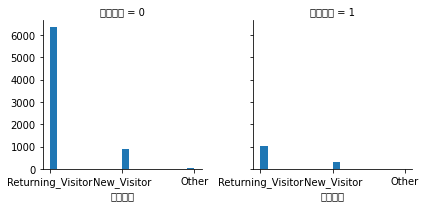

In [38]:
g = sns.FacetGrid(train_df, col='是否购买')
g.map(plt.hist, '访客类型', bins=20)

### 3.1.2 月份与是否购买的关系


/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21542 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36141 missing from current font.
  font.set_text(s, 0.0, flags=fl

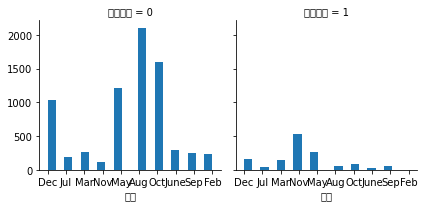

In [39]:
g = sns.FacetGrid(train_df, col='是否购买')
g.map(plt.hist, '月份', bins=20)

### 3.1.3 操作系统与是否购买的关系

/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25805 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 31995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=fl

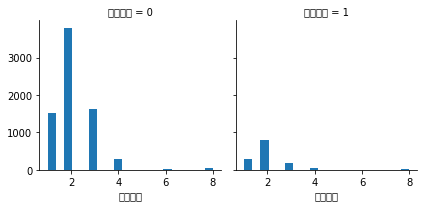

In [40]:
g = sns.FacetGrid(train_df, col='是否购买')
g.map(plt.hist, '操作系统', bins=20)

## 3.2 删除无关列

In [41]:
train_df.drop(['操作系统'], axis=1, inplace=True)

train_df.head()

,访客类型,月份,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买
0,Returning_Visitor,Dec,556.916667,0,0,0.000000,0.022436,0.010256,26,0.0,False,2,0.00,1,8,0.0,0
1,Returning_Visitor,Dec,2348.812500,5,0,39.833333,0.055167,0.020000,34,0.0,False,2,0.00,3,1,0.0,0
2,New_Visitor,June,1570.133333,6,0,89.800000,0.005357,0.000000,26,0.0,True,2,0.00,8,4,0.0,0
3,Returning_Visitor,Dec,821.682540,4,2,159.000000,0.019343,0.000617,33,0.0,False,2,27.75,1,2,0.0,1
4,Returning_Visitor,Jul,584.377778,5,2,38.577778,0.064352,0.000000,7,0.0,True,1,9.00,1,2,0.0,1


## 3.3 查询数据缺失值

In [42]:
total_missingvalues = train_df.isnull().sum()
total_missingvalues

test_total_missingValues = test_df.isnull().sum()
test_total_missingValues

访客类型               0
月份                 0
产品相关页面访问持续时间       0
信息相关页面             0
用户相关页面             0
信息相关页面访问持续时间       0
退出率                0
跳出率                0
产品相关页面             0
网页价值               0
操作系统               0
周末                 0
浏览器                0
用户页面访问持续时间         0
区域                 0
流量类型               0
节假日                0
是否购买            3699
dtype: int64

## 3.4 根据训练集的列可以得到大致如下三种特征：
- 数字列 产品相关页面访问持续时间、产品相关页面访问持续时间、信息相关页面访问持续时间、退出率、
跳出率、网页价值、用户页面访问持续时间、节假日
- 二值列 周末
- 字符列 访客类型、月份

In [43]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
train_df.head(5)

,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买,访客类型_New_Visitor,访客类型_Other,访客类型_Returning_Visitor,月份_Aug,月份_Dec,月份_Feb,月份_Jul,月份_June,月份_Mar,月份_May,月份_Nov,月份_Oct,月份_Sep
0,556.916667,0,0,0.000000,0.022436,0.010256,26,0.0,False,2,0.00,1,8,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,2348.812500,5,0,39.833333,0.055167,0.020000,34,0.0,False,2,0.00,3,1,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,1570.133333,6,0,89.800000,0.005357,0.000000,26,0.0,True,2,0.00,8,4,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,821.682540,4,2,159.000000,0.019343,0.000617,33,0.0,False,2,27.75,1,2,0.0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
4,584.377778,5,2,38.577778,0.064352,0.000000,7,0.0,True,1,9.00,1,2,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0


##  3.5 数据处理

In [44]:
num_columns = ['产品相关页面访问持续时间', '产品相关页面访问持续时间', '信息相关页面访问持续时间', '退出率', '跳出率',
               '网页价值', '用户页面访问持续时间', '节假日']

# zero_to_one_columns = ['']
#
str_columns = ['周末']

for i in tqdm(str_columns):
    lbl = LabelEncoder()
    train_df[i] = lbl.fit_transform(train_df[i].astype(str))
    test_df[i] = lbl.fit_transform(test_df[i].astype(str))


train_df[num_columns] = MinMaxScaler().fit_transform(train_df[num_columns])
test_df[num_columns] = MinMaxScaler().fit_transform(test_df[num_columns])

train_df.head(5)



100%|██████████| 1/1 [00:00<00:00, 113.67it/s]


,产品相关页面访问持续时间,信息相关页面,用户相关页面,信息相关页面访问持续时间,退出率,跳出率,产品相关页面,网页价值,周末,浏览器,用户页面访问持续时间,区域,流量类型,节假日,是否购买,访客类型_New_Visitor,访客类型_Other,访客类型_Returning_Visitor,月份_Aug,月份_Dec,月份_Feb,月份_Jul,月份_June,月份_Mar,月份_May,月份_Nov,月份_Oct,月份_Sep
0,0.008705,0,0,0.000000,0.112179,0.051282,26,0.0,0,2,0.000000,1,8,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,0.036715,5,0,0.011720,0.275833,0.100000,34,0.0,0,2,0.000000,3,1,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,0.024543,6,0,0.026421,0.026786,0.000000,26,0.0,1,2,0.000000,8,4,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,0.012844,4,2,0.046782,0.096717,0.003086,33,0.0,0,2,0.010885,1,2,0.0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
4,0.009135,5,2,0.011351,0.321759,0.000000,7,0.0,1,1,0.003530,1,2,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0


# 4.模型

## 4.1 准备数据集

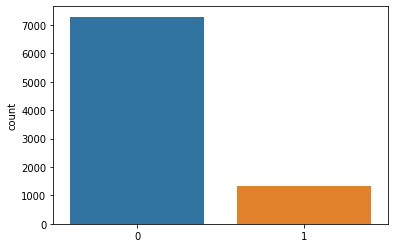

Before OverSampling, counts of label '1': 1336
Before OverSampling, counts of label '0': 7295 



In [45]:
all_columns = [i for i in train_df.columns if i not in ['是否购买']]

train_x, train_y = train_df[all_columns].values, train_df['是否购买'].values
test_x = test_df[all_columns].values
submission['是否购买'] = 0

# 绘制计数直方图
sns.countplot(train_y)
plt.show()

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

## 4.2 训练模型

0:	test: 0.8899918	best: 0.8899918 (0)	total: 109ms	remaining: 21.8s
1:	test: 0.8949806	best: 0.8949806 (1)	total: 226ms	remaining: 22.4s
2:	test: 0.9147311	best: 0.9147311 (2)	total: 340ms	remaining: 22.3s
3:	test: 0.9095635	best: 0.9147311 (2)	total: 460ms	remaining: 22.5s
4:	test: 0.9151861	best: 0.9151861 (4)	total: 566ms	remaining: 22.1s
5:	test: 0.9127428	best: 0.9151861 (4)	total: 669ms	remaining: 21.6s
6:	test: 0.9094664	best: 0.9151861 (4)	total: 770ms	remaining: 21.2s
7:	test: 0.9104171	best: 0.9151861 (4)	total: 871ms	remaining: 20.9s
8:	test: 0.9146698	best: 0.9151861 (4)	total: 989ms	remaining: 21s
9:	test: 0.9129524	best: 0.9151861 (4)	total: 1.11s	remaining: 21.2s
10:	test: 0.9128706	best: 0.9151861 (4)	total: 1.23s	remaining: 21.2s
11:	test: 0.9141996	best: 0.9151861 (4)	total: 1.34s	remaining: 21s
12:	test: 0.9148436	best: 0.9151861 (4)	total: 1.36s	remaining: 19.5s
13:	test: 0.9149356	best: 0.9151861 (4)	total: 1.46s	remaining: 19.4s
14:	test: 0.9156614	best: 0.915661

/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/crius/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813

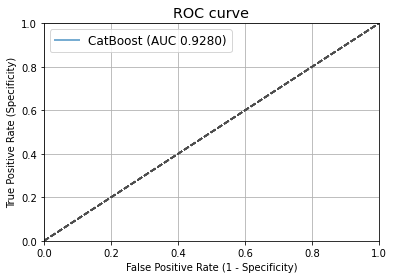

In [46]:
kfold = StratifiedKFold(n_splits=10, shuffle=False)

model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    learning_rate=0.01,
    iterations=200,
    random_seed=42,
    od_type="Iter",
    depth=10,
    #task_type='GPU',
    devices='0',
    early_stopping_rounds=100
    )


for train, valid in kfold.split(train_x, train_y):
    X_train, Y_train = train_x[train], train_y[train]
    X_valid, Y_valid = train_x[valid], train_y[valid]
    model.fit(X_train,Y_train, eval_set=(X_valid, Y_valid),use_best_model=True)
    Y_valid_pred_prob = model.predict_proba(X_valid)
    print("AUC = ", roc_auc_score(Y_valid, Y_valid_pred_prob[:, 1]))
    fpr, tpr, thresholds = roc_curve(Y_valid, Y_valid_pred_prob[:, 1], pos_label=2)
    plt.plot(fpr, tpr, lw=2, alpha=.6)
    plt.plot([0, 1], [0, 1], ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size']=12
    plt.title('ROC curve')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Specificity)")
    plt.legend(["CatBoost (AUC {:.4f})".format(roc_auc_score(Y_valid, Y_valid_pred_prob[:, 1]))])
    plt.grid(True)
    submission['是否购买'] += model.predict_proba(test_x)[:, 1] / 10

In [48]:

submission.to_csv('submission_Catboost.csv',index=False)
